# Chatterbox Turbo TTS Debugging Notebook

This notebook helps debug Chatterbox Turbo TTS audio generation issues.

**Run on Google Colab with GPU enabled:**
- Runtime → Change runtime type → GPU (T4 is sufficient)

**You will need:**
- Hugging Face token with read access

## 1. Setup and Installation

In [1]:
!git clone https://github.com/ahmadshajhan/chatterbox.git
%cd chatterbox
!pip install -e .

fatal: destination path 'chatterbox' already exists and is not an empty directory.
/content/chatterbox
Obtaining file:///content/chatterbox
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for chatterbox-tts (pyproject.toml) ... done
  Created wheel for chatterbox-tts: filename=chatterbox_tts-0.1.6-0.editable-py3-none-any.whl size=6837 sha256=02022e5364ccc660d9c0480c8b904947ecadd98381af561f8ca31d9eda8b322c
  Stored in directory: /tmp/pip-ephem-wheel-cache-kc3_6lfw/wheels/18/55/79/47131f0a1fd00b4fdf3d33198ccc0fe2d12c91f3c108710760
Successfully built chatterbox-tts
  Attempting uninstall: chatterbox-tts
    Found existing installation: chatterbox-tts 0.1.6
    Uninstalling chatterbox-tts-0.1.6:
      Successfully uninstalled chatterbox-tts-0.1.6


In [ ]:
!pip install -q huggingface-hub torchaudio matplotlib librosa soundfile

In [4]:
from huggingface_hub import login
from getpass import getpass

hf_token = getpass("Enter your Hugging Face token: ")
login(token=hf_token)
print("Authenticated with Hugging Face")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


HTTPError: Invalid user token.

In [ ]:
import torch
import torchaudio as ta
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import soundfile as sf
from IPython.display import Audio, display

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

## 2. Load Chatterbox Turbo Model

In [6]:
from chatterbox.tts_turbo import ChatterboxTurboTTS

print("Loading Chatterbox Turbo TTS model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ChatterboxTurboTTS.from_pretrained(device=device)
print(f"Model loaded on {device}")
print(f"Sample rate: {model.sr} Hz")

Loading Chatterbox Turbo TTS model...


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

conds.pt:   0%|          | 0.00/169k [00:00<?, ?B/s]

s3gen.safetensors:   0%|          | 0.00/1.06G [00:00<?, ?B/s]

s3gen_meanflow.safetensors:   0%|          | 0.00/1.06G [00:00<?, ?B/s]

t3_turbo_v1.safetensors:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/470 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

ve.safetensors:   0%|          | 0.00/5.70M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/diffusers/models/lora.py:393: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)


loaded PerthNet (Implicit) at step 250,000
Model loaded on cuda
Sample rate: 24000 Hz


## 3. Helper Functions

In [ ]:
def visualize_audio(wav, sr, title="Audio Waveform"):
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    if isinstance(wav, torch.Tensor):
        wav_np = wav.cpu().numpy().squeeze()
    else:
        wav_np = wav.squeeze()
    
    axes[0].plot(wav_np)
    axes[0].set_title(f"{title} - Waveform")
    axes[0].set_xlabel("Sample")
    axes[0].set_ylabel("Amplitude")
    axes[0].grid(True, alpha=0.3)
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(wav_np)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title(f"{title} - Spectrogram")
    fig.colorbar(img, ax=axes[1], format="%+2.0f dB")
    
    plt.tight_layout()
    plt.show()
    
    print(f"Duration: {len(wav_np) / sr:.2f}s")
    print(f"Shape: {wav_np.shape}")
    print(f"Amplitude: [{wav_np.min():.4f}, {wav_np.max():.4f}]")
    print(f"Mean: {wav_np.mean():.4f}, Std: {wav_np.std():.4f}")

def play_audio(wav, sr):
    if isinstance(wav, torch.Tensor):
        wav_np = wav.cpu().numpy().squeeze()
    else:
        wav_np = wav.squeeze()
    display(Audio(wav_np, rate=sr))

def save_audio(wav, sr, filename):
    if isinstance(wav, torch.Tensor):
        wav_np = wav.cpu().numpy().squeeze()
    else:
        wav_np = wav.squeeze()
    sf.write(filename, wav_np, sr)
    print(f"Saved to {filename}")

## 4. Test 1: Simple Text with Default Parameters

Text: Hello, this is a test.
Using default parameters


  4%|▍         | 41/1000 [00:00<00:15, 61.13it/s]


S3 Token -> Mel Inference...


100%|██████████| 2/2 [00:00<00:00,  9.59it/s]


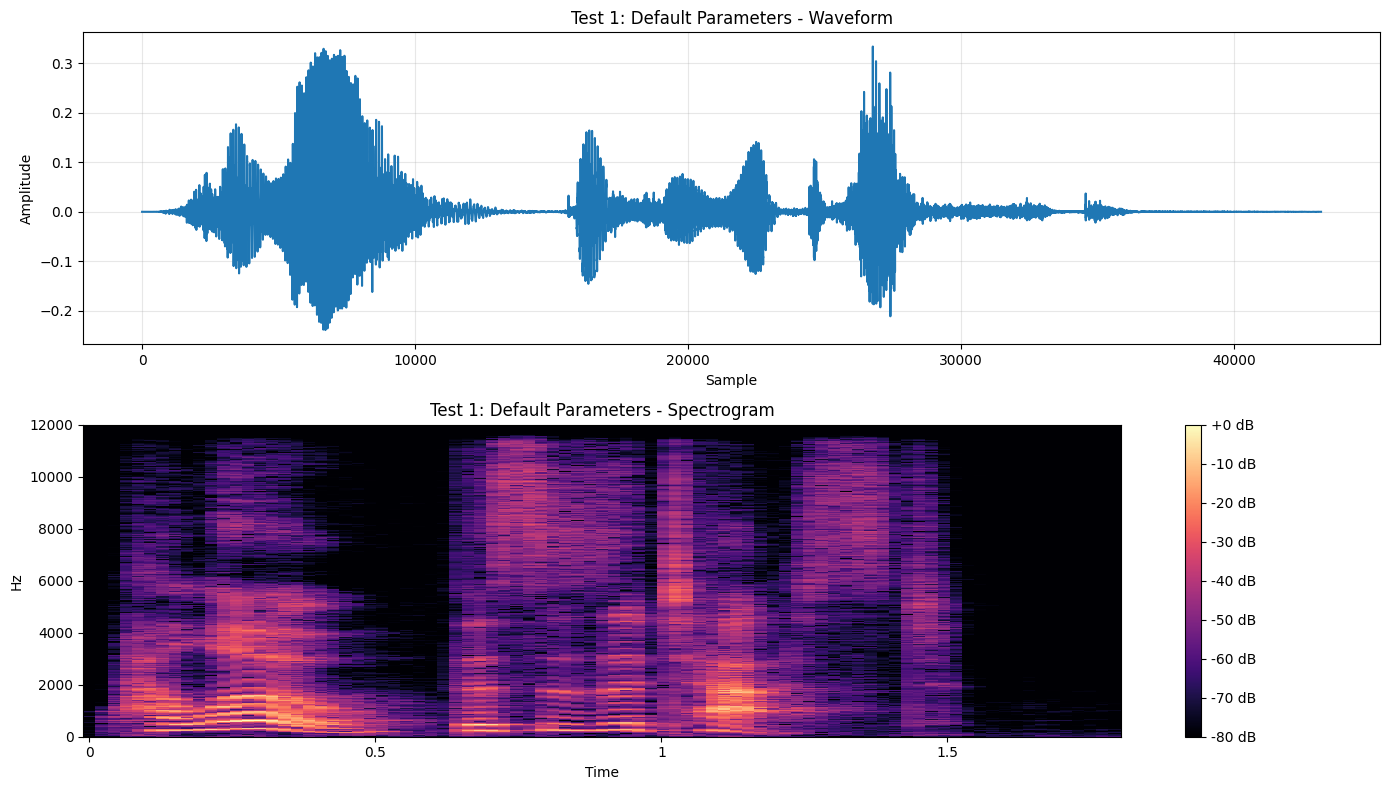

Duration: 1.80s
Shape: (43200,)
Amplitude: [-0.2387, 0.3337]
Mean: -0.0000, Std: 0.0388


ImportError: TorchCodec is required for save_with_torchcodec. Please install torchcodec to use this function.

In [8]:
text = "Hello, this is a test."
print(f"Text: {text}")
print("Using default parameters")

wav = model.generate(text)

visualize_audio(wav, model.sr, "Test 1: Default Parameters")
play_audio(wav, model.sr)
save_audio(wav, model.sr, "test1_default.wav")

## 5. Test 2: Simple Text with Your Parameters

In [ ]:
text = "Hello, this is a test."
print(f"Text: {text}")
print("Using: exaggeration=0.5, cfg_weight=0.5")

wav = model.generate(text, exaggeration=0.5, cfg_weight=0.5, temperature=1.0)

visualize_audio(wav, model.sr, "Test 2: Your Parameters")
play_audio(wav, model.sr)
save_audio(wav, model.sr, "test2_your_params.wav")

## 6. Test 3: Check Model Parameters

In [ ]:
import inspect

signature = inspect.signature(model.generate)
print("ChatterboxTurboTTS.generate() signature:")
print(signature)
print("\nParameters:")
for param_name, param in signature.parameters.items():
    default = param.default if param.default != inspect.Parameter.empty else "required"
    print(f"  {param_name}: {default}")

## 7. Test 4: Different Parameter Combinations

In [ ]:
text = "The quick brown fox jumps over the lazy dog."

tests = [
    {"name": "Default", "params": {}},
    {"name": "Low_exaggeration", "params": {"exaggeration": 0.5}},
    {"name": "High_exaggeration", "params": {"exaggeration": 1.5}},
    {"name": "Low_CFG", "params": {"cfg_weight": 0.3}},
    {"name": "High_CFG", "params": {"cfg_weight": 0.9}},
    {"name": "Your_params", "params": {"exaggeration": 0.5, "cfg_weight": 0.5}},
]

for i, test in enumerate(tests, 1):
    print(f"\n{'='*60}")
    print(f"Test {i}: {test['name']}")
    print(f"Parameters: {test['params']}")
    
    wav = model.generate(text, **test['params'])
    
    filename = f"test4_{test['name']}.wav"
    save_audio(wav, model.sr, filename)
    play_audio(wav, model.sr)

## 8. Test 5: Preprocessed Text

In [ ]:
import re

def preprocess_text(text):
    lines = text.split('\n')
    paragraphs = []
    current = []
    
    for line in lines:
        cleaned = line.strip()
        if not cleaned:
            if current:
                paragraphs.append(' '.join(current))
                current = []
        else:
            current.append(cleaned)
    
    if current:
        paragraphs.append(' '.join(current))
    
    result = '\n\n'.join(paragraphs)
    return re.sub(r' +', ' ', result)

In [ ]:
raw_text = """We loitered the morning away in the garden. Stanley Hopkins had
      gone down to the village to look into some rumours of a strange
      woman who had been seen by some children on the Chatham Road."""

cleaned = preprocess_text(raw_text)

print("Raw text:")
print(repr(raw_text[:100]))
print("\nCleaned text:")
print(repr(cleaned[:100]))

In [ ]:
print("Generating with cleaned text...")
wav_clean = model.generate(cleaned, exaggeration=0.5, cfg_weight=0.5)
save_audio(wav_clean, model.sr, "test5_cleaned.wav")
play_audio(wav_clean, model.sr)

In [ ]:
print("Generating with raw text...")
wav_raw = model.generate(raw_text, exaggeration=0.5, cfg_weight=0.5)
save_audio(wav_raw, model.sr, "test5_raw.wav")
play_audio(wav_raw, model.sr)

## 9. Test 6: Short Sentences

In [ ]:
sentences = [
    "Hello.",
    "This is a test.",
    "The weather is nice today.",
]

for i, s in enumerate(sentences, 1):
    print(f"\nTest {i}: {s}")
    wav = model.generate(s, exaggeration=0.5, cfg_weight=0.5)
    save_audio(wav, model.sr, f"test6_short_{i}.wav")
    play_audio(wav, model.sr)

## 10. Diagnostic Summary

In [ ]:
print("="*60)
print("DIAGNOSTIC QUESTIONS")
print("="*60)
print("1. Does Test 1 sound good?")
print("   YES = Default parameters work")
print("   NO = Model issue")
print("")
print("2. Does Test 2 sound good?")
print("   YES = Your parameters are fine")
print("   NO = Parameters too low")
print("")
print("3. Which Test 4 sounds best?")
print("   Use those parameters!")
print("")
print("4. Test 5: Cleaned better than raw?")
print("   YES = Preprocessing helps")
print("   NO = Not a preprocessing issue")
print("")
print("5. Are Test 6 short sentences clear?")
print("   YES but long text bad = Length issue")
print("="*60)

## 11. List Generated Files

In [ ]:
import glob
import os

files = sorted(glob.glob("test*.wav"))
print(f"Generated {len(files)} test files:\n")
for f in files:
    size = os.path.getsize(f) / 1024
    print(f"  {f} ({size:.1f} KB)")
print("\nDownload from file browser on left")